# 6.1 매개변수 갱신

확률적 경사 하강법 (SGD)

In [1]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr

    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]        

In [2]:
network = TwoLayerNet(...)
optimizer = SGD()

for i in range(10000):
    ...
    x_batch, t_batch = mini_batch(...)
    grads = network.gradient(x_batch, t_batch)
    prams = network.params
    optimizer.update(params, grads)             # 매개변수와 기울기만 넘겨주면 된다.
    ...

NameError: name 'TwoLayerNet' is not defined

**SGD의 단점**: 탐색 경로가 비효율적이다.
- 모멘텀
- AdaGrad
- Adam

In [3]:
# 모멘텀

class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None

    def update(self, params, grads):
        if self.v == None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)

        for key in params.keys():
            self.v[key] = self.momentum * self.v[key] - self.lr*grads[key]
            params[key] += self.v[key]

모멘텀은 SGD와 다르게 진동을 줄이고, 빠르게 수렴하게 돕는다.<br>
곡선이 급한 손실 함수 지형에서 효과적.

#### AdaGrad
각 계층마다 학습률이 조정되기 때문에, 진동하는 움직임이 현저히 줄어든다.

In [4]:
# AdaGrad

class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None

    def update(self, params, grads):
        if self.h in None:
            self.h ={}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)

        for key in params.key():
            self.h[key] += grads[key] * grads[key]         # 기울기 제곱
            params[key] -= (self.lr*grads[key]) / (np.sqrt(self.h[key]) + 1e-7) # 0을 나누지 않도록 1e-7 더해줌

#### Adam
Adam = 모멘텀 + AdaGrad
하이퍼파라미터의 '편향 보정'이 가능하다.


# 6.2 가중치의 초기값

모든 가중치의 초기값을 0으로 설정하면, 순전파에서 은닉층에 같은 값이 입력된다.<br> 
그러면 역전파에서 모두 똑같이 갱신되기 때문에 '대칭적인 구조'를 깨지 못하게 된다.

In [19]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1/(1 + np.exp(-x))

x = np.random.randn(1000, 100) # 입력층이 100개인 1000개의 데이터
node_num = 100                 # 각 은닉층의 노드 수는 100개
hidden_layer_size = 5          # 5개의 은닉층
activations = {}

for i in range(hidden_layer_size):
    input_data = x if i == 0 else activations[i - 1]
    w = np.random.randn(node_num, node_num)
    a = np.dot(x, w)
    z = sigmoid(a)
    activations[i] = z

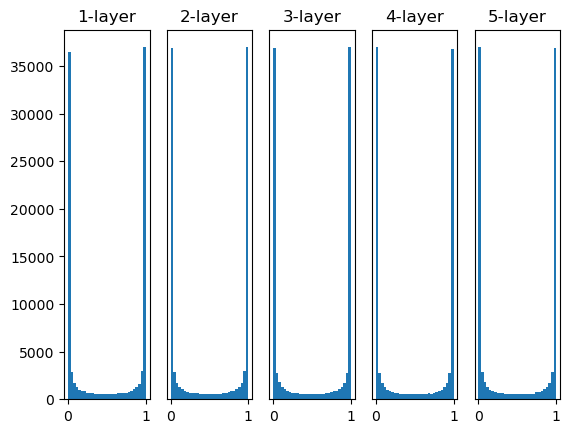

In [12]:
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

각 층마다 활성화값이 0 또는 1로 치우쳐져 있다.<br>
활성화 함수로 사용한 시그모이드는 0 또는 1에 치우쳐 분포하게 되면 역전파의 기울기 값이 점점 작아지다 소실된다 -> **기울기 소실**

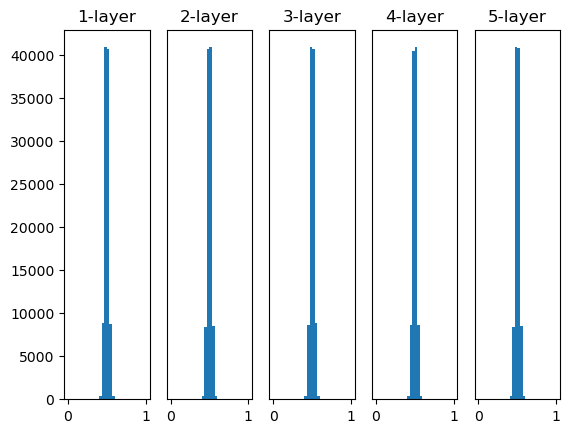

In [15]:
# 가중치의 표준편차를 0.01로 변경
# w =np.random.randn(node_num, node_num) * 0.01

for i in range(hidden_layer_size):
    input_data = x if i == 0 else activations[i - 1]
    w = np.random.randn(node_num, node_num)*0.01
    a = np.dot(x, w)
    z = sigmoid(a)
    activations[i] = z

for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

활성화 값이 0, 1로 치우치지 않았지만 0.5로 모여있다 -> 활성화값이 치우쳐있다는 것은 **표현력을 제한**한다는 것

#### Xavier 초깃값

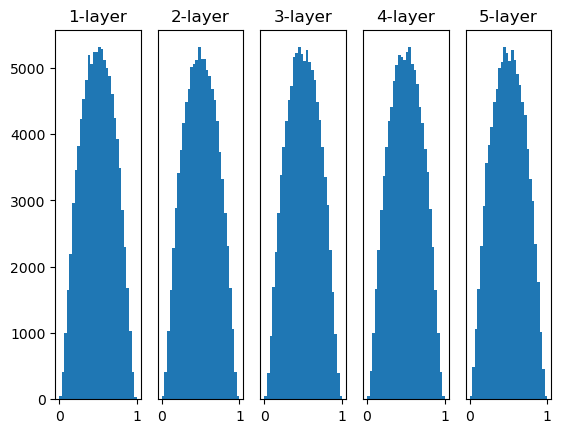

In [21]:
for i in range(hidden_layer_size):
    input_data = x if i == 0 else activations[i - 1]
    w = np.random.randn(node_num, node_num) / np.sqrt(node_num)  # Xavier 초기값: 앞 계층의 노드가 n개라면, 표준편차로 1/sqrt(n)  
    a = np.dot(x, w)
    z = sigmoid(a)
    activations[i] = z

for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

#### ReLu함수를 사용할 때, 가중치 초기값
ReLu 함수는 음수 부분이 0이기 때문에, 더 넓은 분포가 필요해서 표준편차로 sqrt(2/n)을 곱한다.
- ReLu(가중치*0.01)
- ReLu(가중치 * Xavier 초기값)
- ReLu(가중치 * He 초기값)

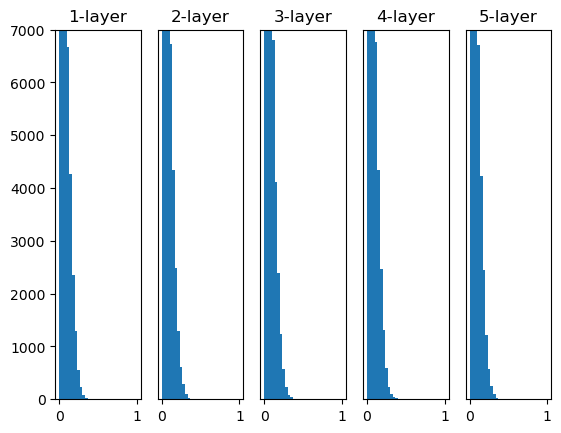

In [29]:
def ReLu(x):
    return np.maximum(0, x)

for i in range(hidden_layer_size):
    input_data = x if i == 0 else activations[i - 1]
    w = np.random.randn(node_num, node_num)*0.01
    a = np.dot(x, w)
    z = ReLu(a)
    activations[i] = z

for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

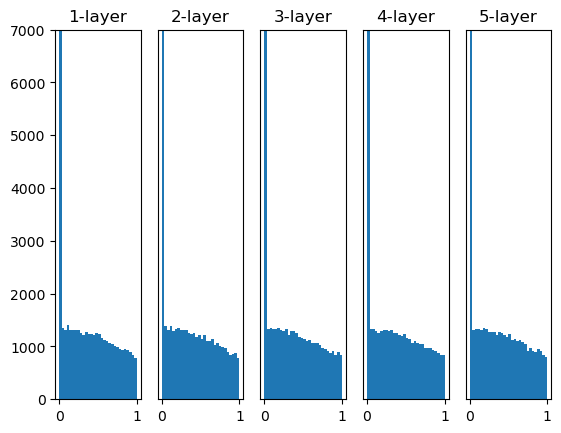

In [31]:
for i in range(hidden_layer_size):
    input_data = x if i == 0 else activations[i - 1]
    w = np.random.randn(node_num, node_num)/np.sqrt(node_num)
    a = np.dot(x, w)
    z = ReLu(a)
    activations[i] = z

for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

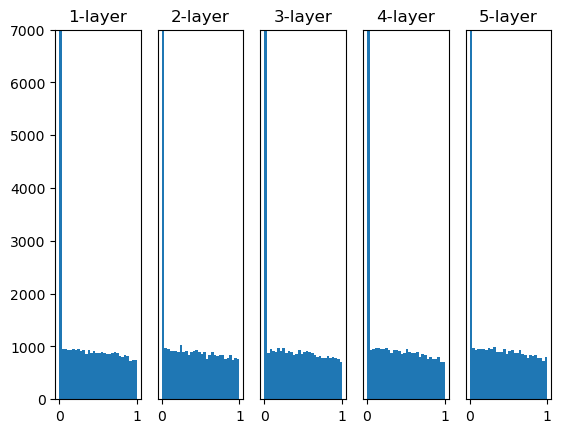

In [33]:
for i in range(hidden_layer_size):
    input_data = x if i == 0 else activations[i - 1]
    w = np.random.randn(node_num, node_num)*np.sqrt(2/node_num)
    a = np.dot(x, w)
    z = ReLu(a)
    activations[i] = z

for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

- 정리<br>
가중치의 초기값은 0으로 두면 역전파에서 모두 똑같이 갱신된다.<br>
활성화 함수(Sigmoid, ReLU)에 따라서, 가중치의 초기값(0, 1사이의 랜덤한 값)을 조정해야한다 -> sigmoid, tanh는 Xavier초기값, ReLU는 He초기값

# 6.3 배치 정규화 (Batch Normalization)
- 학습 속도 개선
- 초기값 의존성 줄여줌
- 과대적합 억제 <br>
기본 아이디어 -> 각 층의 **활성화 값이 적당히 분포**되도록 조정하는 것 (Batch Norm계층 삽입)

평균과 분산을 구하고, (입력-평균)/표준편차를 통해 평균이 0, 분산이 1인 정규화를 진행한다.<br>
**확대(scale)와 이동(shift)** 을 통해 원하는 표준편차를 곱하고 평균을 이동시켜서 데이터의 제한을 유연하게 만든다.